Our dataset is composed of two parts. The first one are the actual images, obtained from the Manga109 dataset. The second part is the metadata of the manga titles that compose this dataset, obtained from the Manga109 website. Let's first take a look on the images of the dataset.

First and foremost, have they all the same resolution?

In [1]:
import os
from skimage.io import imread
from collections import defaultdict

img_extensions = ['.jpg', '.png', '.bmp']

resolution_count = defaultdict(int)
extension_count = defaultdict(int)

root_folder = "./Manga109/images"
for root, dirs, files in os.walk(root_folder):
    for file in files:
        ext = os.path.splitext(file)[1].casefold()
        extension_count[ext] += 1
        if ext.casefold() in img_extensions:
            fullpath = os.path.join(root,file)
            image = imread(fullpath)
            resolution = image.shape
            resolution_count[resolution] += 1


KeyboardInterrupt: 

In [1]:
import pandas as pd

df_resolution = pd.DataFrame.from_dict(resolution_count,orient="index")
df_resolution.columns = ["count"]
df_resolution["pct"] = df_resolution["count"] / df_resolution["count"].sum()
df_resolution.sort_values("count", ascending=False, inplace=True)
df_resolution.head()

NameError: name 'pd' is not defined

It seems for the most part yes. The two main resolutions, accounting for more than 99% of the data are actually the same resolution (One with RGB color channels, and the other black and white pictures).

Now let's take a look on the title metadata. This is the data that we will use to classify the images into the Mangas Target Audience (Shonen, Soujo, Seinen and Josei). First, let's take a look on the frequency of each target.

In [37]:
import pandas as pd

df_target = pd.read_csv("./data/metadata/titles.csv")
df_target.head()

,Num,Title,Folder Name,Author,Age,Publisher,Target,Genre,Pages,Volume in dataset
0,1,1・2・3でキメてあげる,Count3DeKimeteAgeru,Omiya Naoi,1980's,Kadokawa Shoten Publishing,boy,sports,198,1.0
1,2,愛さずにはいられない,AisazuNihaIrarenai,Yoshi Masako,1980's,Shueisha,girl,love romance,187,2.0
2,3,あっけら貫刃帖,AkkeraKanjinchou,Kobayashi Yuki,2000's,Shueisha,boy,battle,183,1.0
3,4,あくはむ,Akuhamu,Arai Satoshi,2000's,Kodansha,boy,four-frame cartoons,161,1.0
4,5,青すぎる春,AosugiruHaru,Okuda Momoko,2000's,Shueisha,lady,love romance,210,NaN


The Target Audience domain contains the translated english terms. As the japanese terms are well known in the international manga readers community, we will use them from this point onwards.

In [39]:
def translate_target(v):
    translation = {
        "lady" : "josei",
        "boy" : "shounen",
        "girl" : "shoujo",
        "young men" : "seinen"
    }
    return translation[v]

df_target["Target"] = df_target["Target"].apply(translate_target)

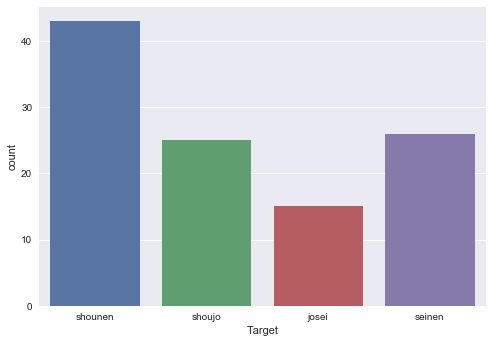

In [4]:
%matplotlib inline
import seaborn as sns

sns.countplot(df_target["Target"])

We see that the most frequent target audience on this dataset is Shounen, followed by Seinen, Shoujo and finally Josei. Let's check the covers of one example of each kind. For this, let's write a helper function to retrieve the covers.

In [1]:
from skimage import io
import os
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

fp = FontProperties(fname='C:/Windows/Fonts/Arial.ttf', size=14)
rcParams['font.family'] = fp.get_name()

def get_page(folder, page):
    "Get a manga page"
    page_folder = "./manga109/images/{folder}/".format(folder=folder)
    sample_filename = os.listdir(page_folder)[0]
    prefix = sample_filename[0:-7]
    page_filename = "{prefix}{page:03d}.jpg".format(prefix=prefix, page=page)
    page_path = os.path.join(page_folder, page_filename)
    return io.imread(page_path)

def get_metadata(folder):
    "Retrieve manga metadata from de df_target dataframe"
    data = df_target[df_target["Folder Name"] == folder]
    return data["Author"].values[0], data["Title"].values[0], data["Target"].values[0]

def format_page(folder, ax):
    "Format the matplotlib ax object and add metadata to it"
    author, title, target = get_metadata(folder)
    ax.grid(False)
    ax.set_title("{title}© \n(Author: {author})".format(title=title, author=author))
    ax.set_xlabel(target)
    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_page(folder,page, ax):
    "Plot the manga cover into an matplotlib ax object"
    img = get_page(folder,page)
    ax.imshow(img)   
    format_page(folder, ax)

     
folders = ["Count3DeKimeteAgeru", "ARMS", "AisazuNihaIrarenai", "AosugiruHaru" ]    
fig, ax = plt.subplots(2,4,figsize=(20,15))

for idx, folder in enumerate(folders):
    plot_page(folder, 0, ax[0,idx])
    plot_page(folder, 10, ax[1,idx])


NameError: name 'df_target' is not defined

Okay. Now that we have some knowledge about our dataset, we can start doing some data-preparation. Most of the images in the dataset follows the A-Series ratio (That is, the long size is greater than the smaller size by a factor of square root of two). This ratio has several useful properties for the paper manufacturing industry (You can cut it at the middle of the long size and still keep the same ratio)

Here, we will try to classify (512,512) images. We cannot simply reshape the images, as the different aspect rations would introduce distortion on our images. Also, we would not like to randomly crop the image, as we can end up with patches where there is nothing interesting going on. 

Let's try to get around this problem. First and foremost, let's get a sample image to test our pipeline

In [6]:
img = get_page("Count3DeKimeteAgeru",10)

As wer want to focus on "interesting" areas of the page, we apply a Canny edge detector to find out where in the image we have some king of drawing. We expect that regions with sharp transitions are regions with more stuff going on.

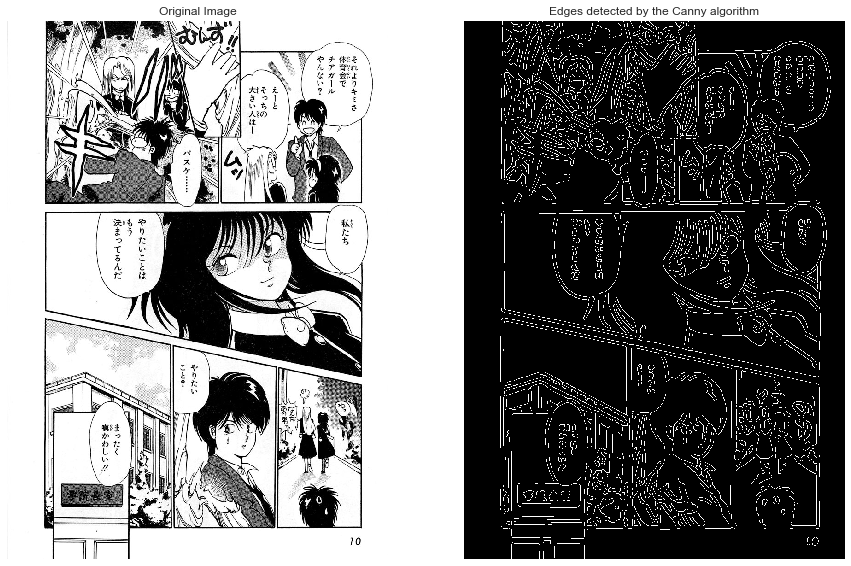

In [7]:
from skimage.feature import canny
from skimage.color import rgb2gray
edges = canny(rgb2gray(img),sigma=3)
fig, ax = plt.subplots(1,2,figsize=(15,15))

ax[0].imshow(img)
ax[1].imshow(~edges)
ax[0].set_title("Original Image")
ax[1].set_title("Edges detected by the Canny algorithm")

for axi in ax:
    axi.grid(False)
    axi.set_xticks([])
    axi.set_yticks([])

That's... Better... I Guess? How can we determine where we want our images slices to be in all that black and white mess? We might try to place the slices centers on the center of the action, that is, in the middle of a "Cluster of Edges". We chose to apply the K-Means algorithm to find out where this edges hot-spots are. 

First, let's convert our data to a format accepted by the algorithm. Here we use scipy sparse coordinate matrix to converte our numpy array into (row, column) format.

In [45]:
from scipy.sparse import coo_matrix
import numpy as np
coo = coo_matrix(edges)
cluster_data = np.zeros((coo.row.shape[0],2),np.uint32)
cluster_data[:,0] = coo.row
cluster_data[:,1] = coo.col

After that, we use sklearn KMeans to get the clusters centroids. A problem with this aproach is that we have to define previously (As a hyperparameter) the number of clusters that we want. Usually, this would be done using methods like Sillhouette analysis, but as we have around 20,000 images to cluster, let's settle for 3.

In [46]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=3)

cluster.fit(cluster_data)
centroids = cluster.cluster_centers_

Now we can see the clusters we obtained for this particular image. Are they any good?

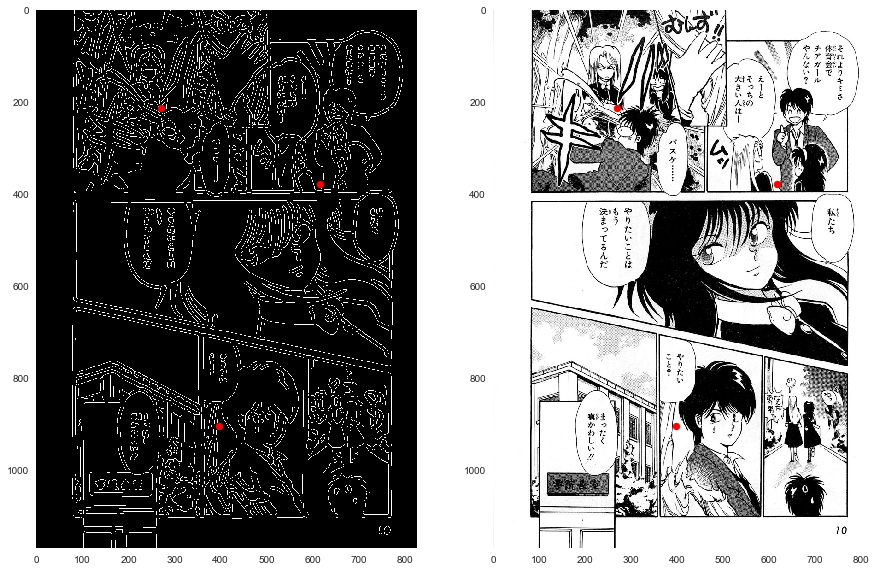

In [48]:
fig, ax = plt.subplots(1,2,figsize=(15,15))

ax[0].imshow(~edges)
ax[0].scatter(centroids[:,1],centroids[:,0], marker="o",s=50, color="red")

ax[1].imshow(img)
ax[1].scatter(centroids[:,1],centroids[:,0], marker="o",s=50, color="red")

for axi in ax:
    axi.grid(False)
    axi.set_xticks([])
    axi.set_yticks([])

Good enough it seems. The rightmost cluster would be better, though, but as our slices consist on a good chunk of the page, ir should not be a problem. Now, let's write a helper function to retrieve those slices based on the centroids we want.

In [52]:
def handle_out_of_borders(img, slice_x, slice_y):
    """handle_out_of_borders
    
    This function get a pair of slices and check if both are within
    the bounds of an image dimensions. If a slice is partially outside the
    image boundaries it will be moved until it's border touch that of the
    image.
    
    If some dimension of the slice is greater than the corresponding dimensions
    on the image, a ValueError Exception will be thrown.
    
    Parameters:
    - img: Numpy array containing the image. Can be 2 or 3 dimensions
    - slice_x: Python slice object containing the x coordinate (Width) slice
    - slice_y: Python slice object containing the y coordinate (height) slice
    
    Returns: Adjusted (slice_x, slice_y) tuple.    
    """
    start_x, end_x = (slice_x.start, slice_x.stop)
    start_y, end_y = (slice_y.start, slice_y.stop)

    img_height = img.shape[0]
    img_width = img.shape[1]
    
    if start_x < 0:
        end_x = end_x + abs(start_x)
        start_x = 0
    if start_y < 0:
        end_y = end_y + abs(start_y)
        start_y = 0
    if end_x >= img_width:
        start_x = start_x - (end_x - img_width + 1)
        end_x = img_width -1
    if end_y >= img_height:
        start_y = start_y - (end_y - img_height)
        end_y = img_height
    
    if start_x < 0 or end_x > img_width:
        raise ValueError("Width of slice is greater than width of image")
    
    if start_y < 0 or end_y > img_height:
        raise ValueError("Height of slice is greater than height of image")   
        
    return slice(start_x, end_x), slice(start_y, end_y)
    

def get_slice(img,centroid,size):
    """get_slice
    
    This function define a slice bounded by the image centered over a coordinate
    (Centroid). If the exact centroid center makes the slice go outside the image,
    it will be adjusted to fit. If the slice cannot be fit inside the image, a
    ValueError exception will be thrown.
    
    Parameters:
    - img: Numpy array containing the image. Can be 2 or 3 dimensions.
    - Centroid: (y, x) tuple containing the centroid coordinates. The usual
    coordinate order is inverted to conform with matplotlib conventions.
    - size: (height, width) tuple containing the slice size
    
    """
    slice_height, slice_width = size

    start_x = int(centroid[1] - slice_width / 2)
    start_y = int(centroid[0] - slice_height / 2)
    
    end_x = start_x + slice_width
    end_y = start_y + slice_height  
    
    slice_x = slice(start_x, end_x)
    slice_y = slice(start_y, end_y)
    
    slice_x, slice_y = handle_out_of_borders(img, slice_x, slice_y)
    
    return img[slice_y, slice_x]

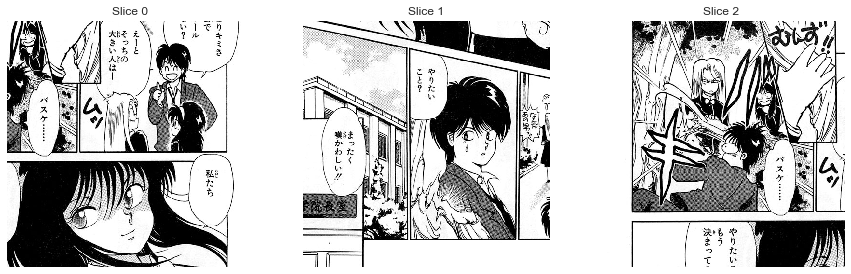

In [53]:
fig, ax = plt.subplots(1,3, figsize=(15,15))

for idx, centroid in enumerate(centroids):
    img_slice = get_slice(img, centroid,size=(512,512))
    ax[idx].imshow(img_slice)
    ax[idx].grid(False)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title("Slice {}".format(idx))

Nice! Finally, let's wrap-up all this in a single pipeline, that we will use to generate slices for all our dataset. The complete function will be available in the transformation module. Let's check if it is working properly.

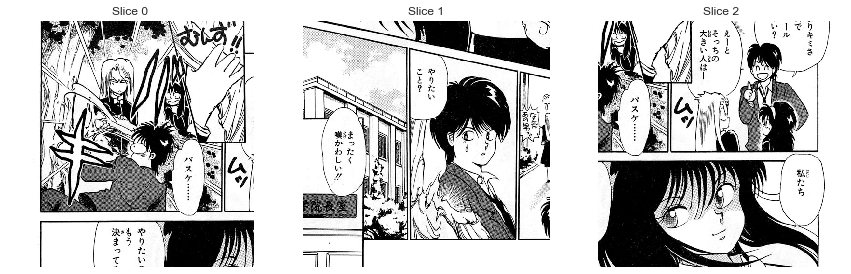

In [56]:
import transformations
%matplotlib inline

from importlib import reload
reload(transformations)

slices, centroids = transformations.generate_slices(img,(512,512))

fig, ax = plt.subplots(1,3, figsize=(15,15))
for idx, img_slice in enumerate(slices):
    ax[idx].imshow(img_slice)
    ax[idx].grid(False)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title("Slice {}".format(idx))

To check if the pipeline is making sense, let's apply it to some random pages of some random manga.

In [91]:
import random 

sample = df_target[["Folder Name", "Pages"]].sample(n=10)

#Choosing a random page among the volume pages
sample["Random Page"] = sample["Pages"].apply(lambda x: random.randint(1,x-1))

sample.head(10)

,Folder Name,Pages,Random Page
54,MiraiSan,213,16
66,ParaisoRoad,210,208
19,EverydayOsakanaChan,171,12
76,Saisoku,199,38
16,DualJustice,197,32
1,AisazuNihaIrarenai,187,88
14,DollGun,191,4
92,PrayerHaNemurenai,197,112
62,NichijouSoup,203,137
91,That'sIzumiko,253,142


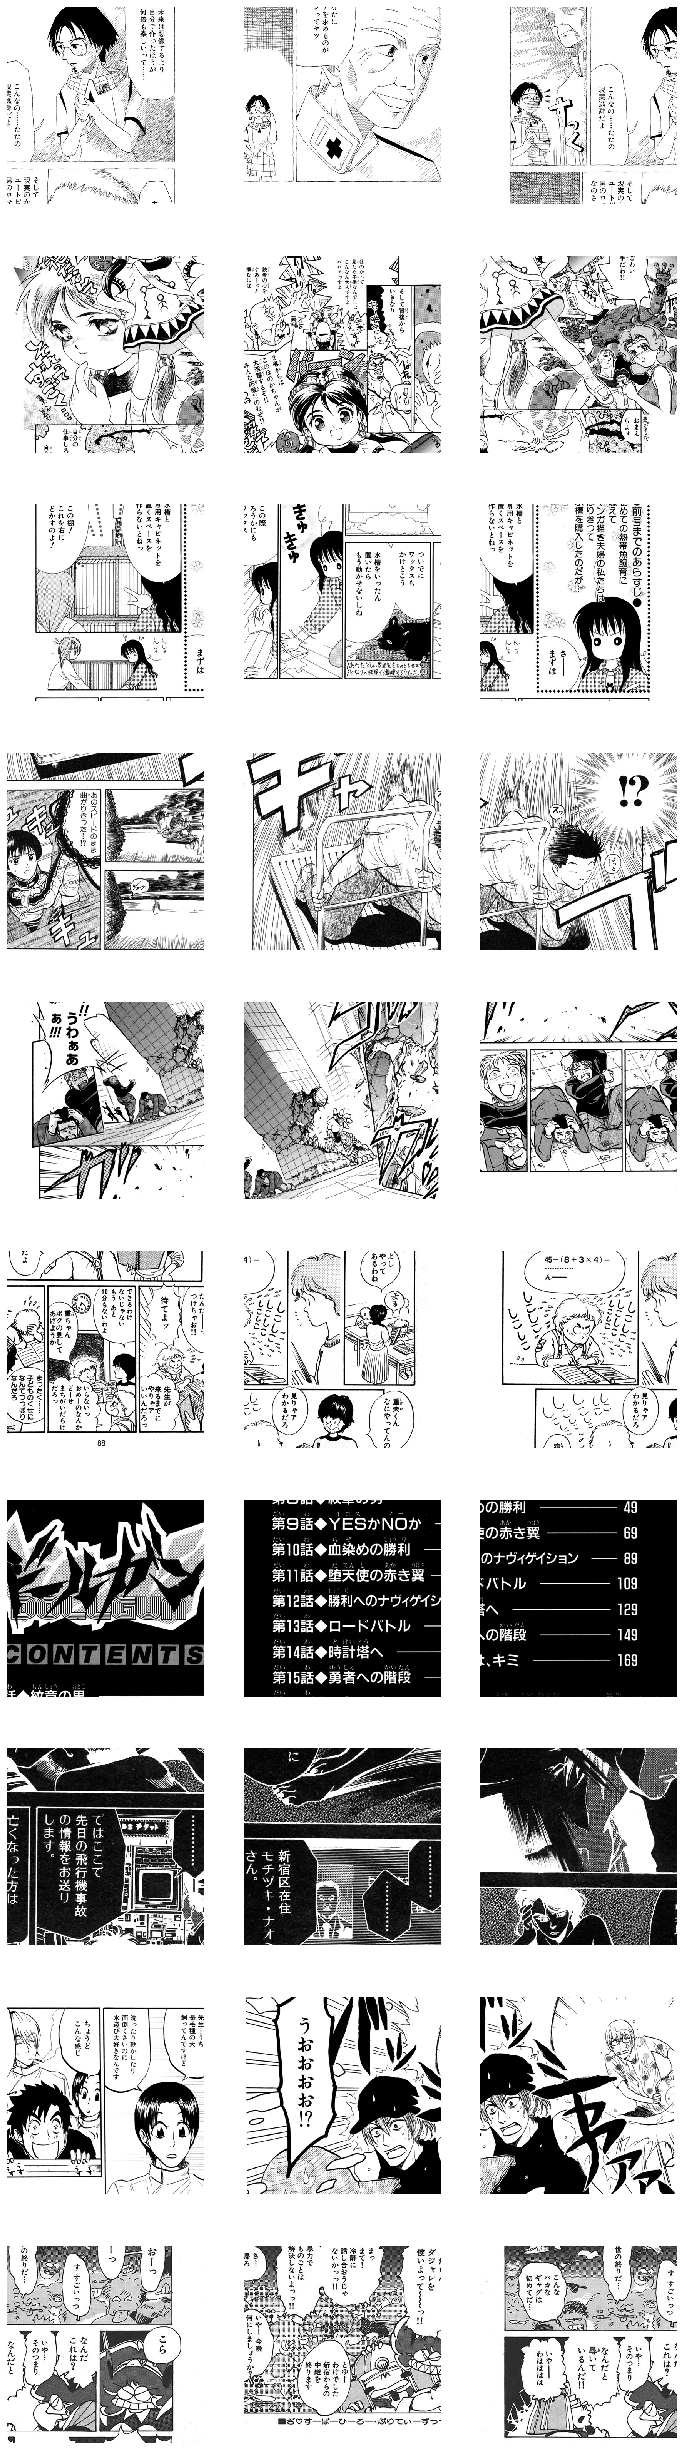

In [106]:
fig, ax = plt.subplots(10, 3, figsize=(12,45))

for row, (_, data) in enumerate(sample.iterrows()):
    img = get_page(data["Folder Name"], data["Random Page"])
    slices, centroids = transformations.generate_slices(img,(512,512))
    for col, img_slice in enumerate(slices):
        ax[row,col].imshow(img_slice)
        ax[row,col].grid(False)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

In [34]:
from skimage import io
from skimage.color import rgb2gray
import transformations
import warnings
from importlib import reload

reload(transformations)

origin = "./manga109/images"
destination = "./transformed"
for folder in os.listdir(origin):
    print(folder)
    origin_folder = os.path.join(origin,folder)
    dest_folder = os.path.join(destination,folder)
    if not os.path.exists(dest_folder):
        os.makedirs()
    for file in os.listdir(origin_folder):
        try:
            filename, ext = os.path.splitext(file)
            img_path = os.path.join(origin_folder,file)
            img = rgb2gray(io.imread(img_path))
            slices, centroids = transformations.generate_slices(img,(512,512))
            for idx, img_slice in enumerate(slices):         
                dest_filename = "{filename}_{idx:02d}{ext}".format(filename=filename,idx=idx,ext=ext)
                #Ignoring low contrast warnings
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")                  
                    io.imsave(os.path.join(dest_folder,dest_filename), img_slice)
        except ValueError as e:
            print(folder, file, str(e))

AisazuNihaIrarenai
AkkeraKanjinchou
Akuhamu
AosugiruHaru
AosugiruHaru AosugiruHaru_053.jpg Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.
AosugiruHaru AosugiruHaru_105.jpg Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.
AosugiruHaru AosugiruHaru_207.jpg Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.
AppareKappore
Arisa
ARMS
ARMS ARMS_002.jpg Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.
BakuretsuKungFuGirl
Belmondo
Belmondo Belmondo_006.jpg Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.
BEMADER_P
BokuHaSitatakaKun
BurariTessenTorimonocho
ByebyeC-BOY
Count3DeKimeteAgeru
DollGun
Donburakokko
DualJustice
EienNoWith
EvaLady
EvaLady EvaLady_215.jpg Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.
EverydayOsakanaChan
GakuenNoise
GarakutayaManta
GinNoChimera
GOOD_KISS_Ver2
Hamlet
Hamlet Hamlet_236.jpg Found arra

In [46]:
df_target[df_target["Target"] == "josei"]

,Num,Title,Folder Name,Author,Age,Publisher,Target,Genre,Pages,Volume in dataset
4,5,青すぎる春,AosugiruHaru,Okuda Momoko,2000's,Shueisha,josei,love romance,210,NaN
20,21,学園ノイズ,GakuenNoise,Inohara Daisuke,2000's,TokyoSanseisya,josei,battle,197,1.0
48,49,ティリニア・シリーズ マジシャンロード,MagicianLoad,Shimada Hirokazu,1980's,Tokuma Shoten Publishing,josei,fantasy,176,NaN
49,50,魔法使い養成専門マジックスター学院☆☆☆,MagicStarGakuin,Minamisawa Hishika,2000's,TokyoSanseisya,josei,fantasy,163,1.0
50,51,マリア様には内緒,MariaSamaNihaNaisho,Konohana Akari,1990's,Shueisha,josei,love romance,193,NaN
61,62,ねこだま,Nekodama,Ebihurai,2010's,Kodansha,josei,humor,234,NaN
62,63,日常スープ,NichijouSoup,Shindou Uni,1990's,TokyoSanseisya,josei,humor,203,NaN
65,66,OLランチ,OL_Lunch,Sanri Youko,1990's,Shogakukan,josei,four-frame cartoons,134,NaN
69,70,プラチナジャングル,PlatinumJungle,Shinohara Masami,1990's,GAKKEN,josei,suspence,171,1.0
72,73,ラファエロ・その愛,Raphael,Satonaka Machiko,1990's,TokyoSanseisya,josei,historical drama,234,NaN
